# Training Materials: Dam Water Level Change Detection with ALOS-2

**Overall Goal:** To equip participants with the skills to detect changes in dam water levels using ALOS-2 satellite data, incorporating slope analysis for mountainous terrain.

## Module 1: ALOS-2 for Water Monitoring

* **1.1 ALOS-2 Data Applications**
    * Focus on disaster monitoring and hydrology/water resource management.
    * Reference: 8.1.1 c
* **1.2 Why use ALOS-2 for Dam Monitoring?** (Highlighting the benefits of SAR for water detection)
* **1.3 Case Study: Yamba Dam, Japan** (Introduce the case study area and the specific problem)

## Module 2: Water Classification with Otsu's Method

* **2.1 Principles of SAR Backscatter for Water Detection**
    * How SAR interacts with water and non-water surfaces.
    * Interpreting backscatter values.
    * Limitations of ALOS-2 data for water detection (e.g., shadows, bare land).
* **2.2 Introduction to Otsu's Method**
    * Theory and concept of Otsu's thresholding for image segmentation.
    * Minimizing intraclass variance.
* **2.3 Implementing Otsu's Method in Python (Scikit-image)**
    * Classifying water using Otsu's method.
    * Visualizing the water mask.
* **2.4 Noise Removal and Post-processing**
    * Applying median filters for noise reduction.
* **2.5 Area Calculation**
    * Calculating the water area from the classified image.
* **2.6 Raster to Vector Conversion (Optional)**
    * Converting the raster water mask to a vector polygon.

In [1]:
pip install rasterio

  Using cached rasterio-1.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached rasterio-1.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl (24.1 MB)
Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from skimage import filters
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from skimage.restoration import denoise_tv_chambolle

**1. Load and Visualizing ALOS-2 Data**

Ensure the data is radiometrically calibrated. If not already calibrated, convert the raw data (e.g., Digital Numbers) to backscatter coefficients (sigma0 or gamma0), which are essential for accurate analysis.

In [6]:
# Load the ALOS-2 image
image_path = '/home/jovyan/shared/Arissara/genAI/processed_images/processed_IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif'

In [7]:
# Load the ALOS-2 image
with rasterio.open(image_path) as src:
    image = src.read(1)  # Reading the first band (HH or HV)
    profile = src.profile
    transform = src.transform
    bounds = src.bounds

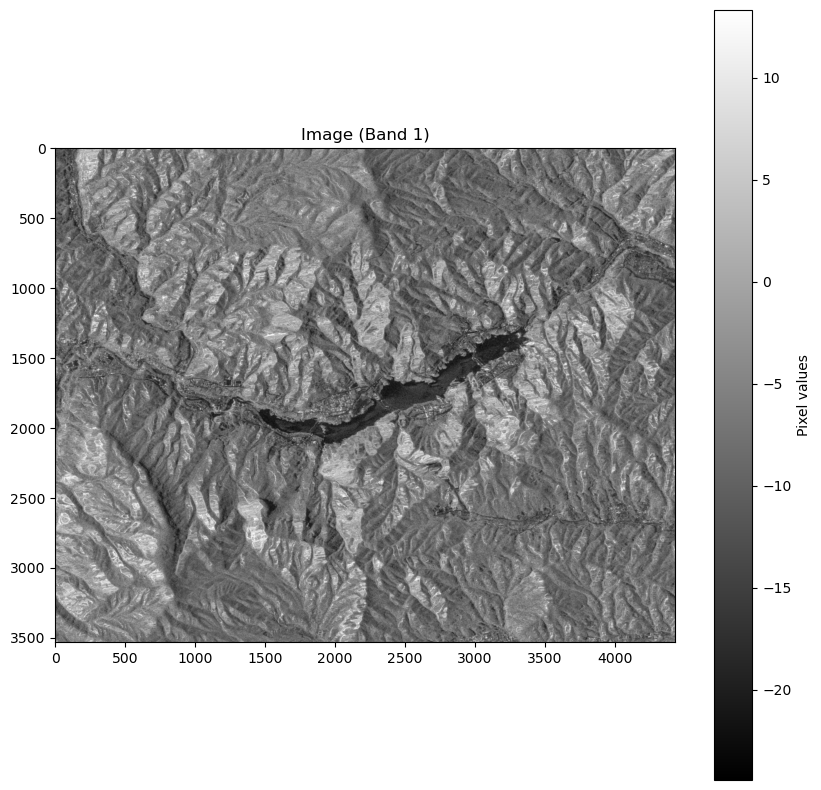

In [10]:
# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title('Image (Band 1)')
plt.colorbar(label='Pixel values')
plt.show()

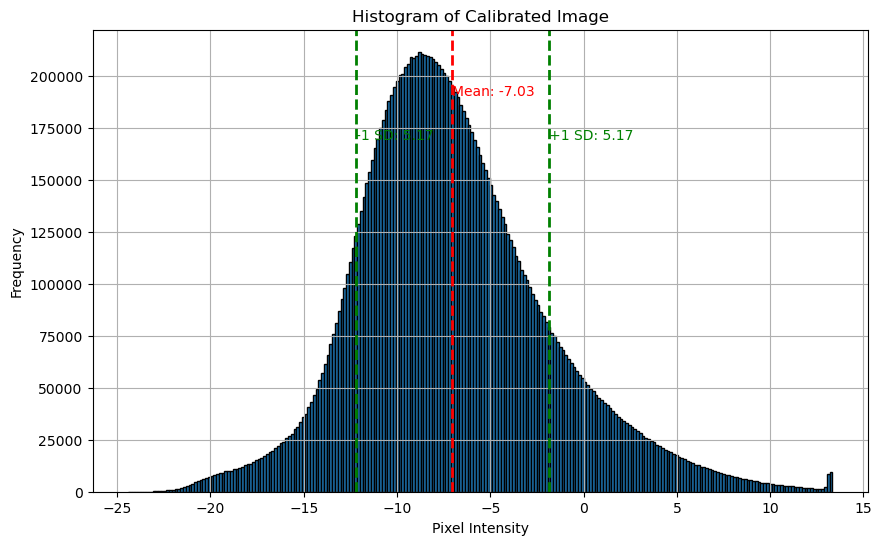

In [11]:
# Compute the histogram for the original image
hist, bin_edges = np.histogram(image, bins=255)
mean_val = np.mean(image)
var_val = np.var(image)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Calibrated Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

**2. Apply Otsu's Thresholding**

Otsu's method calculates an optimal threshold value that minimizes intra-class variance between two classes (water and non-water).

In [12]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(image)
print(f"Otsu's Threshold for SAR Image: {threshold}")

Otsu's Threshold for SAR Image: -5.920228004455566


In [13]:
# Create the binary water mask
water_mask = image < threshold

**3. Post-Process**

Apply filtering to refine the mask and reduce noise. A median filter is common for this purpose.

The step below use a **median filter** to remove noise from the water mask because it is highly effective at preserving edges while removing small, isolated noise artifacts.

Using a **3x3 window** in the median filter, small noise is smoothed out, while larger features, like water bodies, remain intact, ensuring a cleaner and more accurate representation of the water areas.

**4. Visualize the Results**

Visualize the original SAR image and the resulting water mask for verification.

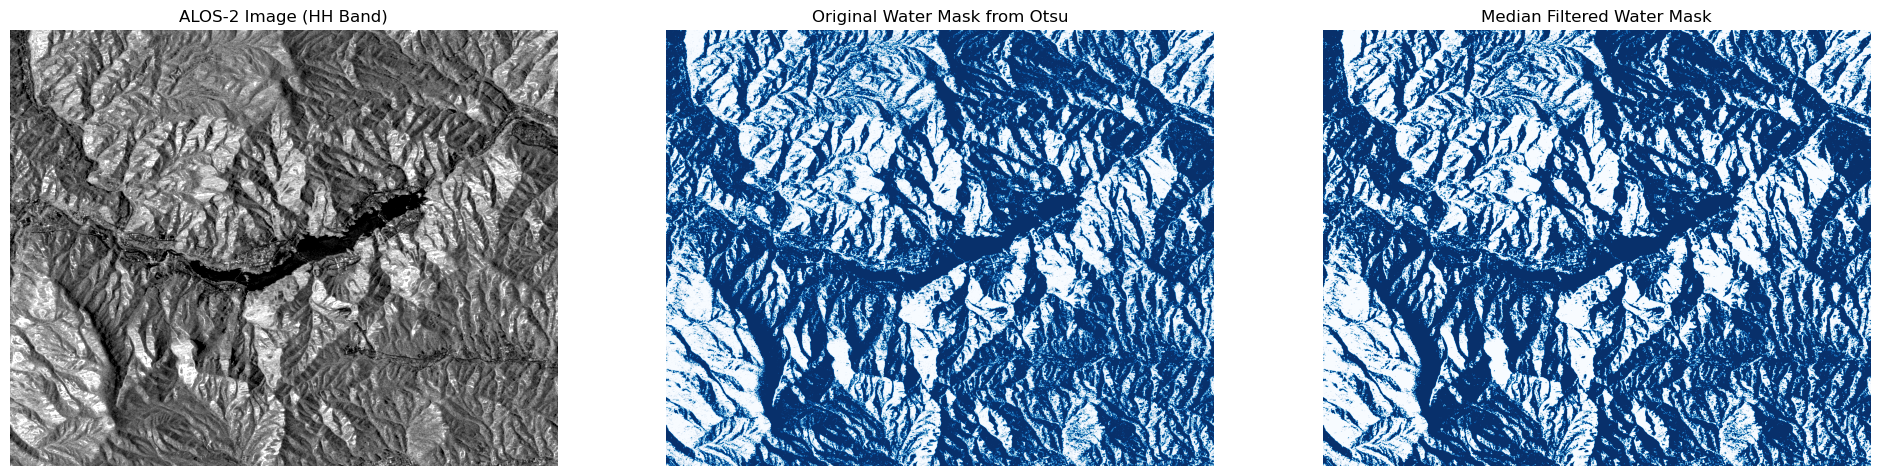

In [16]:
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from scipy.ndimage import median_filter  # Import the median_filter from scipy.ndimage

# Apply the median filter to remove noise from the water mask
# Define the size of the median filter (footprint size equivalent to disk radius 2)
water_mask_filtered = median_filter(water_mask, size=3)  # Use size 3 for a 3x3 window

# Visualize the filtered image, water mask, and median-filtered mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Display filtered ALOS-2 image
vmin = np.percentile(image, 2)
vmax = np.percentile(image, 98)
ax1.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('ALOS-2 Image (HH Band)')
ax1.axis('off')

# Display the original water mask
ax2.imshow(water_mask, cmap='Blues')
ax2.set_title('Original Water Mask from Otsu')
ax2.axis('off')

# Display the median-filtered water mask
ax3.imshow(water_mask_filtered, cmap='Blues')
ax3.set_title('Median Filtered Water Mask')
ax3.axis('off')


plt.show()

## Module 3: Incorporating Slope Analysis for Mountainous Terrain

* 3.1 Importance of Slope Data
    * Terrain effects on SAR backscatter.
    * Reducing false positives in water detection.

* 3.2 Generating Slope Maps from DEM
    * Using `numpy.gradient` to calculate slope.
    * Visualizing and exporting slope maps (hands-on example).

* 3.3 Integrating Slope with Otsu's Method
    * Applying slope thresholds to refine classification.
    * Combining slope and Otsu's output (hands-on example).

In [14]:
# Load the slope
slope_path = '/home/jovyan/shared/Arissara/ALOS-2/Yamba/Finalize/Yamba_slope.tif'  # Update this with the path to the slope file

In [15]:
# Load the slope raster
with rasterio.open(slope_path) as slope_src:
    slope = slope_src.read(1)  # Read the first band of slope data
    slope_profile = slope_src.profile

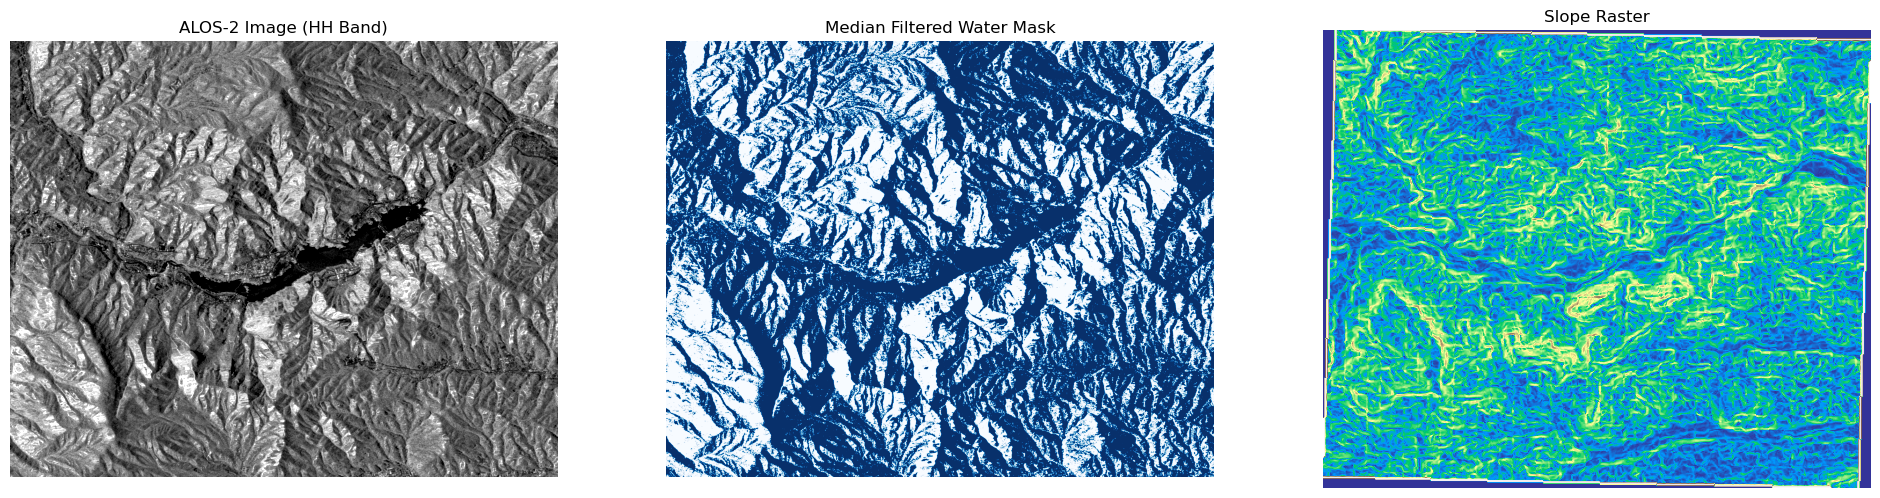

In [17]:
# Visualize the filtered image, water mask, and slope data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Display filtered ALOS-2 image
vmin = np.percentile(image, 2)
vmax = np.percentile(image, 98)
ax1.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('ALOS-2 Image (HH Band)')
ax1.axis('off')

# Display the water mask
ax2.imshow(water_mask_filtered, cmap='Blues')
ax2.set_title('Median Filtered Water Mask')
ax2.axis('off')

# Display the slope data
ax3.imshow(slope, cmap='terrain')
ax3.set_title('Slope Raster')
ax3.axis('off')

plt.show()

* 3.4 Comparing Different Slope Thresholds
    * Analyzing results with varying slope thresholds (5°, 10°, 15°).
    * Determining the optimal threshold based on the study area.

##### Slope 5 degree

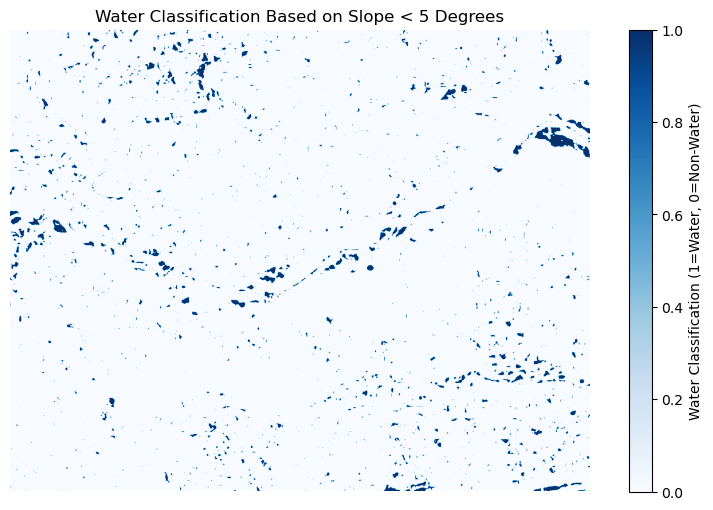

In [18]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def resample_raster(source_raster, target_raster_shape, target_transform, target_crs):
    # Create an empty array for the resampled slope data
    resampled_raster = np.empty(target_raster_shape, dtype=source_raster.dtype)
    
    # Perform the reprojection/resampling
    with rasterio.Env():
        reproject(
            source=source_raster,
            destination=resampled_raster,
            src_transform=slope_src.transform,
            src_crs=slope_src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear  # You can choose other resampling methods (e.g., nearest, cubic)
        )
    
    return resampled_raster

# Resample the slope data to match the water mask dimensions
with rasterio.open(slope_path) as slope_src:
    slope_resampled = resample_raster(
        slope_src.read(1),  # The slope data (first band)
        water_mask.shape,  # Target shape (same as water_mask)
        transform,  # The transform of the water mask
        profile['crs']  # The CRS of the water mask
    )

# Classify based on slope threshold (<5 degrees for water, >=5 degrees for non-water)
water_classification5 = np.where(slope_resampled < 5, 1, 0)  # 1 for water, 0 for non-water

# Optionally, combine this classification with a water mask filter if you want to refine results
# water_mask_filtered = (water_mask == 1)  # Assuming water_mask is binary
# water_classification = np.where(water_mask_filtered, water_classification, np.nan)

# Plot the classified water and non-water areas
plt.figure(figsize=(10, 6))
plt.imshow(water_classification5, cmap='Blues')  # Blue for water, white for non-water
plt.colorbar(label='Water Classification (1=Water, 0=Non-Water)')
plt.title('Water Classification Based on Slope < 5 Degrees')
plt.axis('off')
plt.show()

##### Area Calculation

In [19]:
# Assuming roi is defined in meters: (min_x, min_y, max_x, max_y)
roi = [287059.2127999999793246, 4042672.420500000007450, 298134.2127999999793246, 4051494.9205000000074506]

# Get the pixel width and height in meters from the transformation matrix
pixel_width_m = abs(profile['transform'][0])  # Directly in meters
pixel_height_m = abs(profile['transform'][4])  # Directly in meters

# Calculate the area of one pixel in square meters
pixel_area = pixel_width_m * pixel_height_m
print(f"Pixel area (in square meters): {pixel_area:.2f}")

# Calculate the area covered by water in hectares (assuming water_classification5 is a binary mask of water)
# Multiply the sum of water pixels by the area of each pixel, then convert to hectares (1 hectare = 10,000 square meters)
water_area_ha = np.sum(water_classification5) * pixel_area / 10000  # Convert to hectares
print(f'Water Area: {water_area_ha:.2f} hectares')

Pixel area (in square meters): 6.25
Water Area: 244.67 hectares


##### Export image

In [24]:
from rasterio.transform import from_origin

# Assuming slope_resampled, transform, and profile are already available from previous code

# Classify based on slope threshold (<5 degrees for water, >=5 degrees for non-water)
water_classification5 = np.where(slope_resampled < 5, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water

# Export the classified water data as a GeoTIFF
output_path = "/home/jovyan/shared/Arissara/genAI/output/5degree_water_classification.tif"

# Open a new file to write the GeoTIFF
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=water_classification5.shape[0],  # Make sure the shape is correct
    width=water_classification5.shape[1],
    count=1,  # Number of bands
    dtype=water_classification5.dtype,  # Ensure correct dtype
    crs=profile.get('crs', 'EPSG:32653'),  # Use the CRS from the original raster, or set a default EPSG code
    transform=transform,  # Use the transform from the original raster
    compress='lzw',  # Optional: Compress to reduce file size
    nodata=255  # Adjust nodata value, ensure it makes sense for your data
) as dst:
    dst.write(water_classification5, 1)  # Write the classification array to the first band
    dst.update_tags(1, description="Water classification (1=water, 0=non-water)")

print(f"Water classification has been exported to {output_path}")

Water classification has been exported to /home/jovyan/shared/Arissara/genAI/output/5degree_water_classification.tif


##### Slope 10 degree

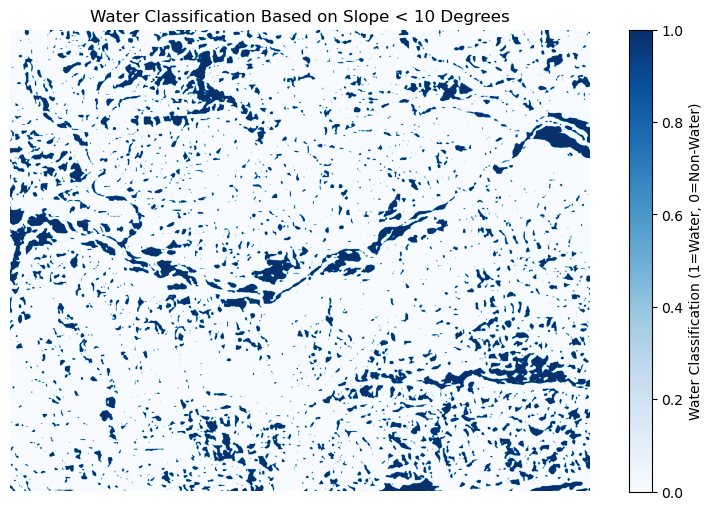

In [20]:
def resample_raster(source_raster, target_raster_shape, target_transform, target_crs):
    # Create an empty array for the resampled slope data
    resampled_raster = np.empty(target_raster_shape, dtype=source_raster.dtype)
    
    # Perform the reprojection/resampling
    with rasterio.Env():
        reproject(
            source=source_raster,
            destination=resampled_raster,
            src_transform=slope_src.transform,
            src_crs=slope_src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear  # You can choose other resampling methods (e.g., nearest, cubic)
        )
    
    return resampled_raster

# Resample the slope data to match the water mask dimensions
with rasterio.open(slope_path) as slope_src:
    slope_resampled = resample_raster(
        slope_src.read(1),  # The slope data (first band)
        water_mask.shape,  # Target shape (same as water_mask)
        transform,  # The transform of the water mask
        profile['crs']  # The CRS of the water mask
    )

# Classify based on slope threshold (<10 degrees for water, >=10 degrees for non-water)
water_classification10 = np.where(slope_resampled < 10, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water, and set dtype to uint8

# Optionally, combine this classification with a water mask filter if you want to refine results
# water_mask_filtered = (water_mask == 1)  # Assuming water_mask is binary
# water_classification = np.where(water_mask_filtered, water_classification, np.nan)

# Plot the classified water and non-water areas
plt.figure(figsize=(10, 6))
plt.imshow(water_classification10, cmap='Blues')  # Blue for water, white for non-water
plt.colorbar(label='Water Classification (1=Water, 0=Non-Water)')
plt.title('Water Classification Based on Slope < 10 Degrees')
plt.axis('off')
plt.show()

##### Area Calculation

In [21]:
# Assuming roi is defined in meters: (min_x, min_y, max_x, max_y)
roi = [287059.2127999999793246, 4042672.420500000007450, 298134.2127999999793246, 4051494.9205000000074506]

# Get the pixel width and height in meters from the transformation matrix
pixel_width_m = abs(profile['transform'][0])  # Directly in meters
pixel_height_m = abs(profile['transform'][4])  # Directly in meters

# Calculate the area of one pixel in square meters
pixel_area = pixel_width_m * pixel_height_m
print(f"Pixel area (in square meters): {pixel_area:.2f}")

# Calculate the area covered by water in hectares (assuming water_classification5 is a binary mask of water)
# Multiply the sum of water pixels by the area of each pixel, then convert to hectares (1 hectare = 10,000 square meters)
water_area_ha = np.sum(water_classification10) * pixel_area / 10000  # Convert to hectares
print(f'Water Area: {water_area_ha:.2f} hectares')

Pixel area (in square meters): 6.25
Water Area: 1403.47 hectares


##### Export image

In [25]:
# Assuming slope_resampled, transform, and profile are already available from previous code

# Classify based on slope threshold (<10 degrees for water, >=10 degrees for non-water)
water_classification10 = np.where(slope_resampled < 10, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water

# Export the classified water data as a GeoTIFF
output_path = "/home/jovyan/shared/Arissara/genAI/output/10degree_water_classification.tif"

# Open a new file to write the GeoTIFF
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=water_classification10.shape[0],  # Make sure the shape is correct
    width=water_classification10.shape[1],
    count=1,  # Number of bands
    dtype=water_classification10.dtype,  # Ensure correct dtype
    crs=profile.get('crs', 'EPSG:32653'),  # Use the CRS from the original raster, or set a default EPSG code
    transform=transform,  # Use the transform from the original raster
    compress='lzw',  # Optional: Compress to reduce file size
    nodata=255  # Adjust nodata value, ensure it makes sense for your data
) as dst:
    dst.write(water_classification10, 1)  # Write the classification array to the first band
    dst.update_tags(1, description="Water classification (1=water, 0=non-water)")

print(f"Water classification has been exported to {output_path}")

Water classification has been exported to /home/jovyan/shared/Arissara/genAI/output/10degree_water_classification.tif


##### Slope 15 degree

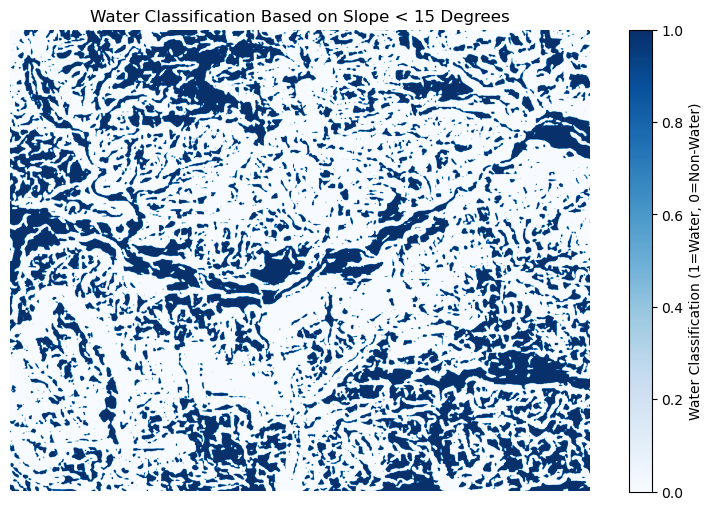

In [22]:
def resample_raster(source_raster, target_raster_shape, target_transform, target_crs):
    # Create an empty array for the resampled slope data
    resampled_raster = np.empty(target_raster_shape, dtype=source_raster.dtype)
    
    # Perform the reprojection/resampling
    with rasterio.Env():
        reproject(
            source=source_raster,
            destination=resampled_raster,
            src_transform=slope_src.transform,
            src_crs=slope_src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear  # You can choose other resampling methods (e.g., nearest, cubic)
        )
    
    return resampled_raster

# Resample the slope data to match the water mask dimensions
with rasterio.open(slope_path) as slope_src:
    slope_resampled = resample_raster(
        slope_src.read(1),  # The slope data (first band)
        water_mask.shape,  # Target shape (same as water_mask)
        transform,  # The transform of the water mask
        profile['crs']  # The CRS of the water mask
    )

# Classify based on slope threshold (<15 degrees for water, >=15 degrees for non-water)
water_classification15 = np.where(slope_resampled < 15, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water, and set dtype to uint8

# Optionally, combine this classification with a water mask filter if you want to refine results
# water_mask_filtered = (water_mask == 1)  # Assuming water_mask is binary
# water_classification = np.where(water_mask_filtered, water_classification, np.nan)

# Plot the classified water and non-water areas
plt.figure(figsize=(10, 6))
plt.imshow(water_classification15, cmap='Blues')  # Blue for water, white for non-water
plt.colorbar(label='Water Classification (1=Water, 0=Non-Water)')
plt.title('Water Classification Based on Slope < 15 Degrees')
plt.axis('off')
plt.show()

##### Area Calculation

In [23]:
# Assuming roi is defined in meters: (min_x, min_y, max_x, max_y)
roi = [287059.2127999999793246, 4042672.420500000007450, 298134.2127999999793246, 4051494.9205000000074506]

# Get the pixel width and height in meters from the transformation matrix
pixel_width_m = abs(profile['transform'][0])  # Directly in meters
pixel_height_m = abs(profile['transform'][4])  # Directly in meters

# Calculate the area of one pixel in square meters
pixel_area = pixel_width_m * pixel_height_m
print(f"Pixel area (in square meters): {pixel_area:.2f}")

# Calculate the area covered by water in hectares (assuming water_classification5 is a binary mask of water)
# Multiply the sum of water pixels by the area of each pixel, then convert to hectares (1 hectare = 10,000 square meters)
water_area_ha = np.sum(water_classification15) * pixel_area / 10000  # Convert to hectares
print(f'Water Area: {water_area_ha:.2f} hectares')

Pixel area (in square meters): 6.25
Water Area: 3261.41 hectares


##### Export image

In [26]:
# Assuming slope_resampled, transform, and profile are already available from previous code

# Classify based on slope threshold (<15 degrees for water, >=15 degrees for non-water)
water_classification15 = np.where(slope_resampled < 15, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water

# Export the classified water data as a GeoTIFF
output_path = "/home/jovyan/shared/Arissara/genAI/output/15degree_water_classification.tif"

# Open a new file to write the GeoTIFF
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=water_classification15.shape[0],  # Make sure the shape is correct
    width=water_classification15.shape[1],
    count=1,  # Number of bands
    dtype=water_classification15.dtype,  # Ensure correct dtype
    crs=profile.get('crs', 'EPSG:32653'),  # Use the CRS from the original raster, or set a default EPSG code
    transform=transform,  # Use the transform from the original raster
    compress='lzw',  # Optional: Compress to reduce file size
    nodata=255  # Adjust nodata value, ensure it makes sense for your data
) as dst:
    dst.write(water_classification15, 1)  # Write the classification array to the first band
    dst.update_tags(1, description="Water classification (1=water, 0=non-water)")

print(f"Water classification has been exported to {output_path}")

Water classification has been exported to /home/jovyan/shared/Arissara/genAI/output/15degree_water_classification.tif


#### Summary

The result of using slope threshold <5 degrees for water, >=5 degrees for non-water is **better** than using slope threshold <10 degrees and <15 degrees for water area.

Classifying water and non-water areas based on **slope threshold** helps improve the accuracy of distinguishing between these surfaces in topographically complex regions, like mountainous or hilly terrain. Water bodies are generally found on flat or gently sloping areas, while non-water surfaces are more likely to occur on steeper slopes.

##### Why a Slope Threshold < 5° is Better:
- **Water Behavior**: Water typically accumulates and spreads over flat surfaces. A lower slope threshold (e.g., **< 5 degrees**) more accurately captures flat or near-flat areas where water bodies are likely to exist.
- **Precision**: A threshold of **5°** offers a more precise separation between water and non-water compared to higher thresholds. Using higher thresholds, like **10°** or **15°**, may misclassify slightly sloping non-water areas (e.g., hilly , shadow of the mountainland) as water, reducing classification accuracy.
- **Steeper Thresholds Increase Errors**: At thresholds like **10°** or **15°**, the classifier may include sloped terrains as water, leading to overestimation of water areas and misclassification of non-water regions in hilly or mountainous environments.

Thus, using a slope threshold of **< 5 degrees** for water and **≥ 5 degrees** for non-water provides a more reliable and accurate classification in rugged landscapes.

#### Convert raster to vector (Optional)

In [32]:
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import numpy as np

In [33]:
# Path to the input raster file
input_raster = '/home/jovyan/shared/Arissara/genAI/output/5degree_water_classification.tif'
output_vector = '/home/jovyan/shared/Arissara/genAI/output/5degree_water_classification.gpkg'  # You can change to .geojson or .gpkg

In [34]:
# Open the raster file using rasterio
with rasterio.open(input_raster) as src:
    # Read the first band (or all bands depending on your needs)
    raster = src.read(1)
    
    # Get the affine transform to preserve the spatial coordinates
    transform = src.transform
    
    # Get the coordinate reference system (CRS)
    crs = src.crs

# Optional: Threshold the raster (e.g., binary mask)
# This is only required if you want to extract certain areas based on the raster values
binary_raster = raster > 0  # Example threshold, adjust based on your data

# Vectorize the raster using rasterio.features.shapes to generate polygons
results = (
    {'properties': {'value': v}, 'geometry': shape(s)}
    for s, v in shapes(binary_raster.astype(np.int16), transform=transform)
)

# Convert the result to a GeoDataFrame (which supports geospatial vector data)
geoms = list(results)
gdf = gpd.GeoDataFrame.from_features(geoms, crs=crs.to_string())  # Set CRS to match the raster

# Save the vectorized output to a file (Shapefile, GeoJSON, GPKG)
gdf.to_file(output_vector, driver="GPKG")  # You can change the format here

# Optionally, display a summary of the vector data
print(gdf.head())

                                            geometry  value
0  POLYGON ((287854.66 4051494.383, 287854.66 405...    1.0
1  POLYGON ((293237.16 4051494.383, 293237.16 405...    1.0
2  POLYGON ((294234.66 4051486.883, 294234.66 405...    1.0
3  POLYGON ((288012.16 4051491.883, 288012.16 405...    1.0
4  POLYGON ((296107.16 4051491.883, 296107.16 405...    1.0
